In [1]:
import os
import numpy as np
from PIL import Image
from torch.utils import data
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.autograd import Variable
import torchvision.transforms as transforms

## ---------------------- ResNet VAE ---------------------- ##

class ResNet_VAE(nn.Module):
    def __init__(self, fc_hidden1=1024, fc_hidden2=768, drop_p=0.3, CNN_embed_dim=256):
        super(ResNet_VAE, self).__init__()

        self.fc_hidden1, self.fc_hidden2, self.CNN_embed_dim = fc_hidden1, fc_hidden2, CNN_embed_dim

        # CNN architechtures
        self.ch1, self.ch2, self.ch3, self.ch4 = 16, 32, 64, 128
        self.k1, self.k2, self.k3, self.k4 = (5, 5), (3, 3), (3, 3), (3, 3)      # 2d kernal size
        self.s1, self.s2, self.s3, self.s4 = (2, 2), (2, 2), (2, 2), (2, 2)      # 2d strides
        self.pd1, self.pd2, self.pd3, self.pd4 = (0, 0), (0, 0), (0, 0), (0, 0)  # 2d padding

        # encoding components
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.fc1 = nn.Linear(resnet.fc.in_features, self.fc_hidden1)
        self.bn1 = nn.BatchNorm1d(self.fc_hidden1, momentum=0.01)
        self.fc2 = nn.Linear(self.fc_hidden1, self.fc_hidden2)
        self.bn2 = nn.BatchNorm1d(self.fc_hidden2, momentum=0.01)
        # Latent vectors mu and sigma
        self.fc3_mu = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)      # output = CNN embedding latent variables
        self.fc3_logvar = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)  # output = CNN embedding latent variables

        # Sampling vector
        self.fc4 = nn.Linear(self.CNN_embed_dim, self.fc_hidden2)
        self.fc_bn4 = nn.BatchNorm1d(self.fc_hidden2)
        self.fc5 = nn.Linear(self.fc_hidden2, 64 * 4 * 4)
        self.fc_bn5 = nn.BatchNorm1d(64 * 4 * 4)
        self.relu = nn.ReLU(inplace=True)

        # Decoder
        self.convTrans6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=self.k4, stride=self.s4,
                               padding=self.pd4),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ReLU(inplace=True),
        )
        self.convTrans7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=self.k3, stride=self.s3,
                               padding=self.pd3),
            nn.BatchNorm2d(8, momentum=0.01),
            nn.ReLU(inplace=True),
        )

        self.convTrans8 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=self.k2, stride=self.s2,
                               padding=self.pd2),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.Sigmoid()    # y = (y1, y2, y3) \in [0 ,1]^3
        )


    def encode(self, x):
        x = self.resnet(x)  # ResNet
        x = x.view(x.size(0), -1)  # flatten output of conv

        # FC layers
        x = self.bn1(self.fc1(x))
        x = self.relu(x)
        x = self.bn2(self.fc2(x))
        x = self.relu(x)
        # x = F.dropout(x, p=self.drop_p, training=self.training)
        mu, logvar = self.fc3_mu(x), self.fc3_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        x = self.relu(self.fc_bn4(self.fc4(z)))
        x = self.relu(self.fc_bn5(self.fc5(x))).view(-1, 64, 4, 4)
        x = self.convTrans6(x)
        x = self.convTrans7(x)
        x = self.convTrans8(x)
        x = F.interpolate(x, size=(224, 224), mode='bilinear')
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconst = self.decode(z)

        return x_reconst, z, mu, logvar

In [4]:
import torch
from torchvision import transforms
from PIL import Image

# モデルの読み込み
model_path = './results_cifar10/model_epoch20.pth'
model = ResNet_VAE(fc_hidden1=1024, fc_hidden2=1024, drop_p=0.2, CNN_embed_dim=256)
model.load_state_dict(torch.load(model_path))
model.eval()

# 画像の前処理
image_path = "C:\\Users\\syudi\\neuralnet\\bubblejet\\bubblejet\\datasetVAEtest\\180\\1129_0.png"
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
image = Image.open(image_path).convert('RGB')
image = transform(image).unsqueeze(0)  # バッチサイズの次元を追加

# 潜在変数の取り出し
with torch.no_grad():
    mu, logvar = model.encode(image)
    z = model.reparameterize(mu, logvar)

print('潜在変数 z:', z)


C:\Users\syudi\AppData\Local\Temp\ipykernel_22684\1408720015.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


潜在変数 z: tensor([[-1.8423e+00, -5.9754e-01, -2.1146e+00,  8.7096e+00, -9.8295e+00,
          3.0182e+00, -1.3391e+00, -3.6916e+00,  8.0494e-01, -1.7130e-01,
          4.3120e+00,  2.1310e+00,  5.3209e+00, -8.1914e-01, -8.9400e+00,
         -5.7026e+00,  4.4469e+00, -2.2050e+00, -2.1407e+00,  8.0805e+00,
          4.5126e+00, -2.8243e+00, -2.4227e+00,  2.2172e+00,  6.1345e-01,
         -2.6283e+00, -9.0696e+00,  2.0680e-01, -6.1558e-03,  3.1360e+00,
         -9.9341e+00,  1.0106e+00,  1.9377e-01, -5.1421e+00, -2.8881e+00,
         -1.4502e+00, -5.0266e-01,  1.0442e-01, -6.4799e+00,  6.5978e-02,
         -1.0581e+00, -4.9327e+00,  5.5741e+00, -3.5601e+00,  1.2503e+00,
         -6.1302e+00, -2.5788e+00, -4.2432e+00, -3.9874e-01,  2.1908e+00,
         -2.0264e-01, -3.6818e+00, -3.0180e+00, -3.6782e+00,  1.9255e+00,
          6.8491e-01,  2.5558e+00,  1.8369e+00,  4.5170e+00,  1.8004e+00,
         -2.9164e+00,  4.0380e+00, -3.5228e+00,  2.6338e+00, -3.7490e+00,
          1.0885e+01, -5.2234e

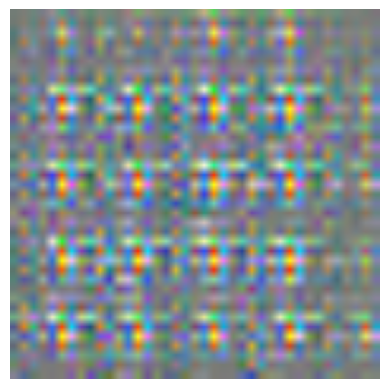

In [6]:
import matplotlib.pyplot as plt

# 画像を生成する
with torch.no_grad():
    generated_image = model.decode(z)  # 潜在変数から画像を生成

# 生成された画像を表示する
def tensor_to_image(tensor):
    tensor = tensor.squeeze(0).cpu()  # バッチサイズの次元を削除
    tensor = tensor.clamp(0, 1)  # 値を [0, 1] にクリップ
    image = transforms.ToPILImage()(tensor)  # PIL画像に変換
    return image

# 画像の変換
image_to_display = tensor_to_image(generated_image)

# 画像の表示
plt.imshow(image_to_display)
plt.axis('off')  # 軸を非表示
plt.show()